In [1]:
#pip install matplotlib
#pip install kaggle

In [ ]:
# This is trianing on the dataset I created by centering the faces in celebA

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import json
import os
import time
from PIL import Image, ImageDraw, ImageFilter, ImageOps


#Very hacky fix to make matplotlib work on my pc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

base_dir = "/home/fsuser/" # install git repo in this directory
repo_dir = base_dir + "de-identification/"
data_path = repo_dir+"downloaded-data/"

Random Seed:  999


In [14]:
################# Download dataset on Fluidstack ###############

# Setting up Kaggle - copying api key from repo to .kaggle folder
with open(repo_dir+'kaggle-apikey.json') as f:
    kaggle_apikey = json.load(f)

#Setting up and connecting to Kaggle API
kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir)
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): 
    print("making folder: ", kaggle_dir)
    os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

# open file at ~/.kaggle/kaggle.json and print it
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print('~/.kaggle/kaggle.json ==', f.read())

if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)

!kaggle config set -n path -v {data_path}

base_dir: /home/fsuser/
kaggle_dir: /home/fsuser/.kaggle
~/.kaggle/kaggle.json == {"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}


In [16]:
! kaggle datasets download jamesdavey/celeba-faces-cropped

zip_path = data_path+"datasets/jamesdavey/celeba-faces-cropped/celeba-faces-cropped.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

 99%|███████████████████████████████████████▋| 297M/299M [00:18<00:00, 24.5MB/s]
100%|████████████████████████████████████████| 299M/299M [00:18<00:00, 16.9MB/s]


In [3]:
datapath = data_path+"celeba_faces_cropped/"

workers = 2 # Number of workers for dataloader
batch_size = 128 # Batch size during training

num_epochs = 10 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
version = 'detection-10-epochs'

Images for /home/fsuser/de-identification/downloaded-data/celeba_faces_cropped/


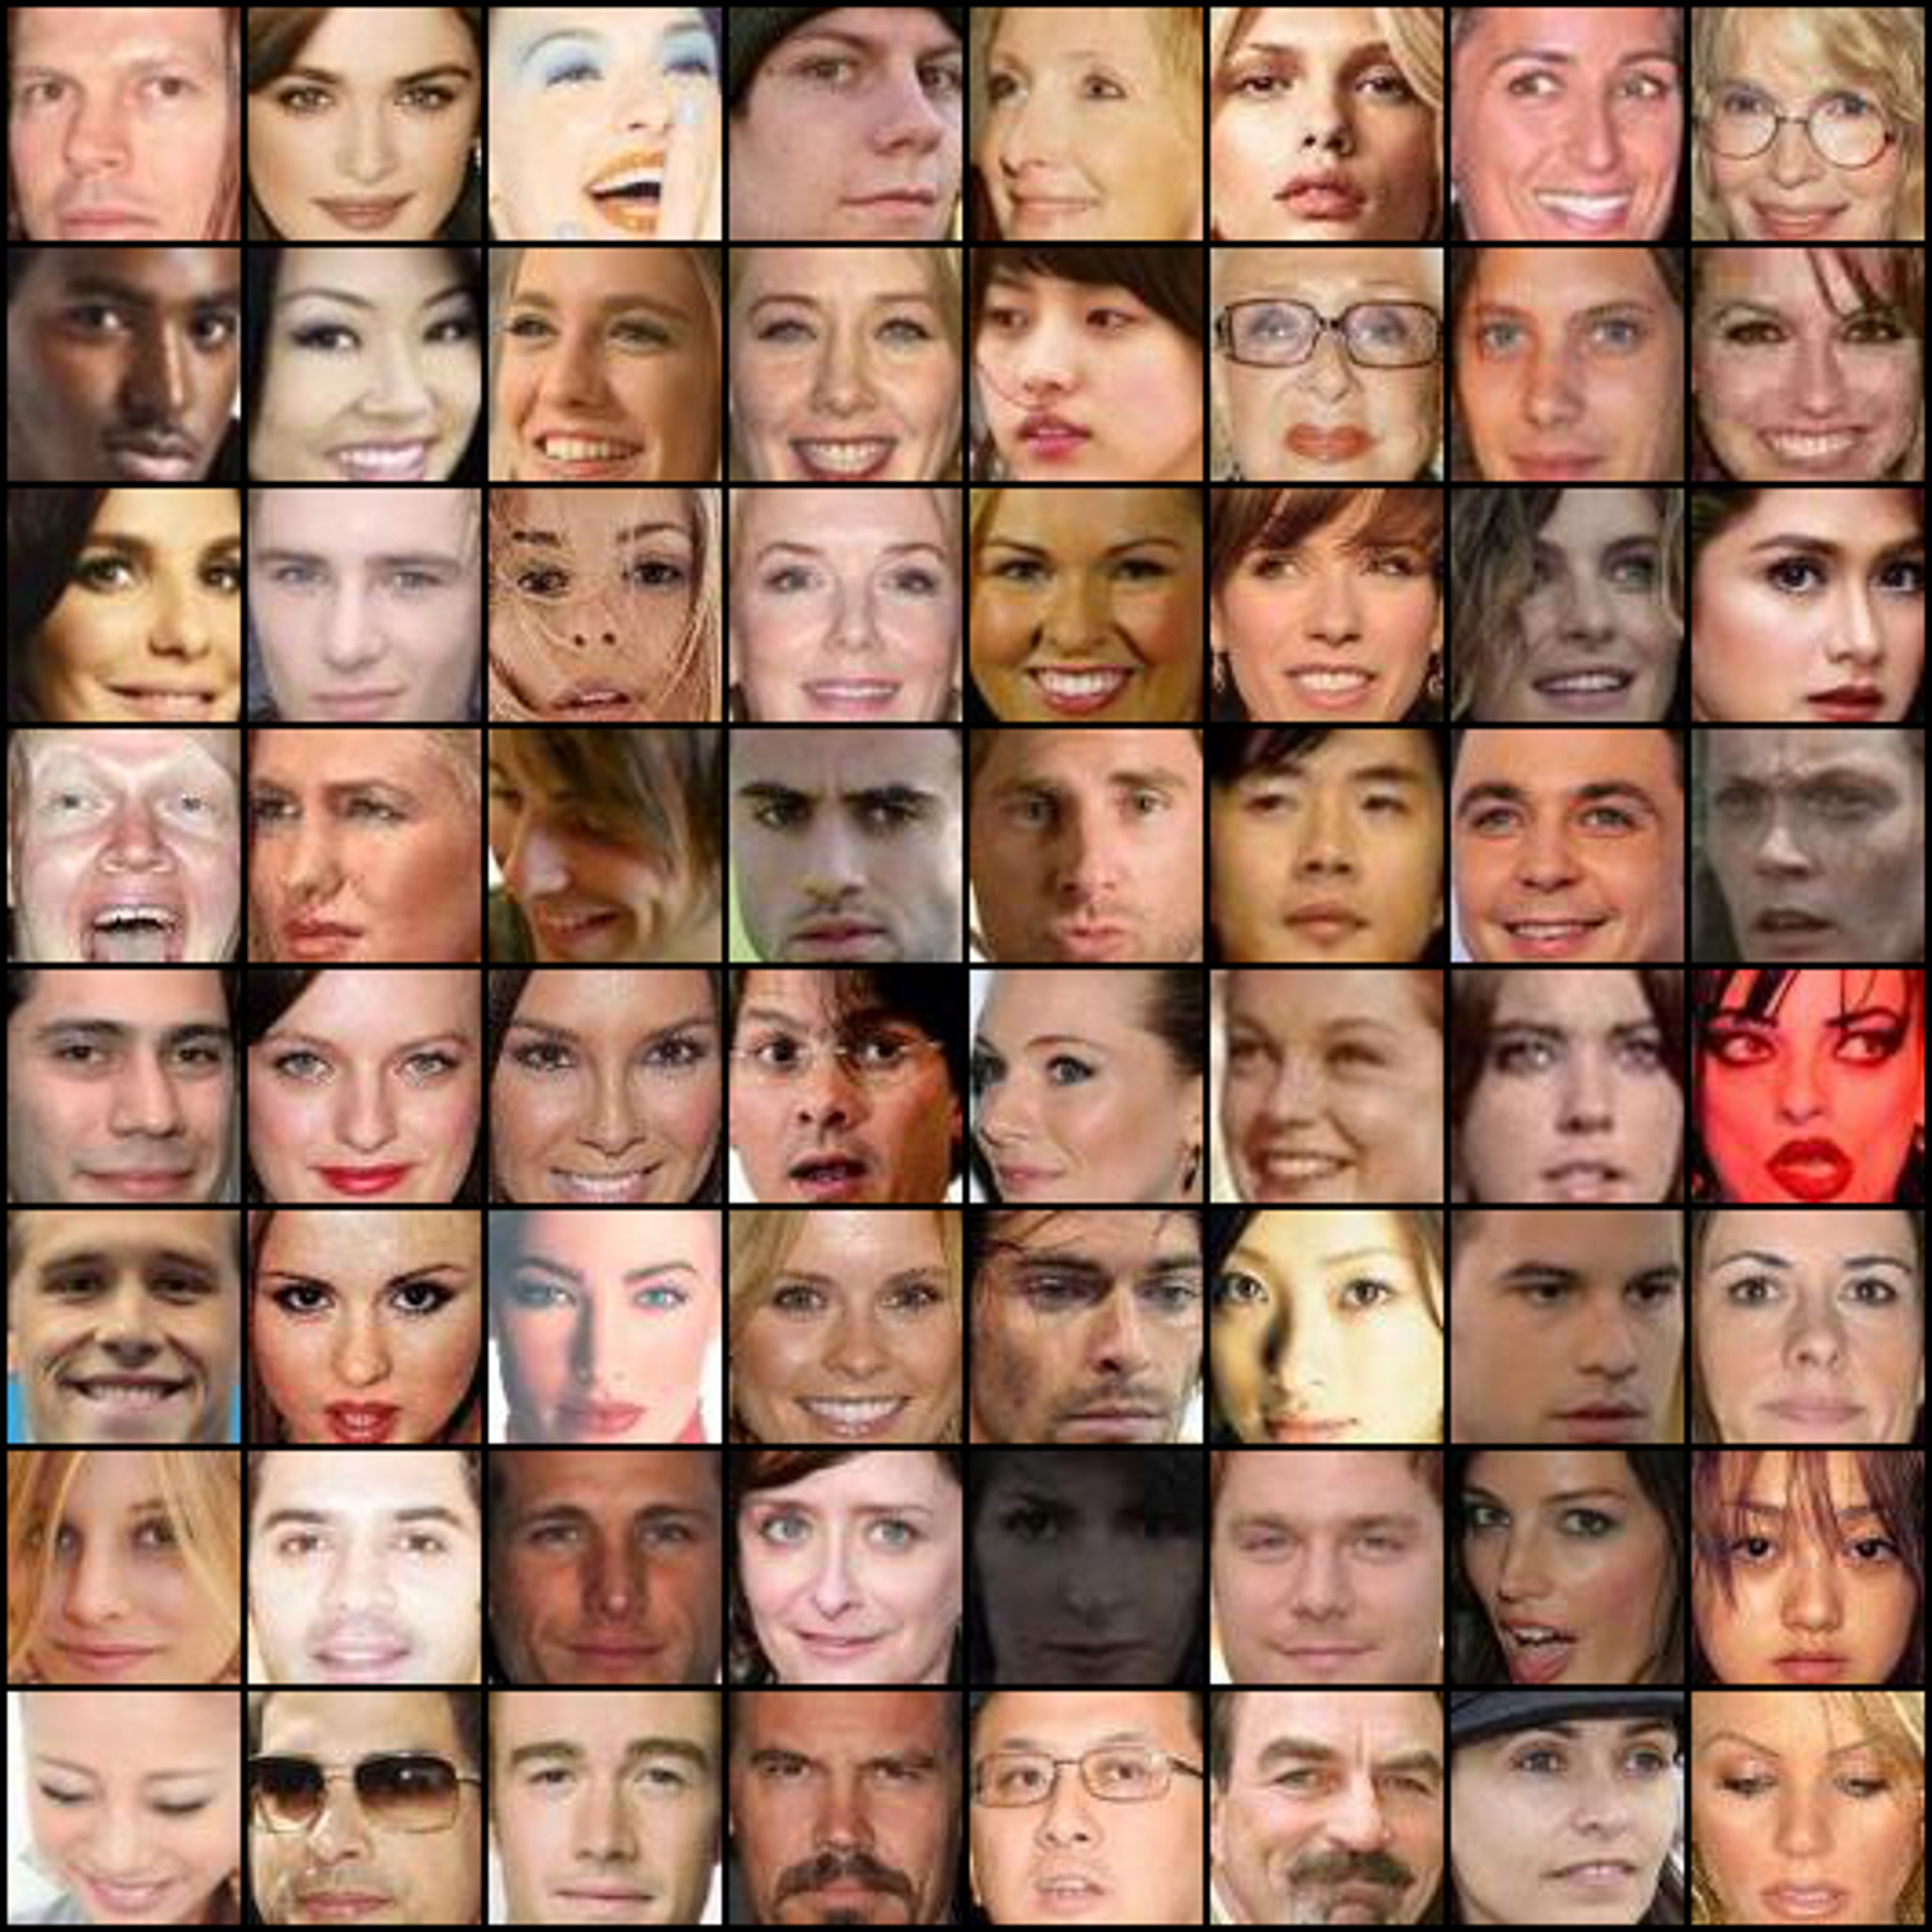

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.all_imgs = list(sorted(os.listdir(root)))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        image = Image.open(self.root+self.all_imgs[idx])
        image = self.transform(image)
        return image

print(f"Images for {datapath}")

img_transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

assert len(os.listdir(datapath)) > 0, "No images found in data path"
dataset = ImageDataset(datapath, img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
batch = next(iter(dataloader))
display_img = Image.fromarray((vutils.make_grid(batch[:64], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (2048,2048)))

In [5]:
nz = 100 # Size of z latent vector (i.e. size of generator input)
nc = 3 # Number of channels in the training images. For color images this is 3
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
### Create the generator ###
netG = Generator(ngpu).to(device)
netG.apply(weights_init) # ``mean=0``, ``stdev=0.02``
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
### Create the Discriminator ###
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init) # ``to mean=0, stdev=0.2``.
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
t_start = time.time()
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f Time : %.2fs'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time() - t_start))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1581]	Loss_D: 1.6290	Loss_G: 6.5319	D(x): 0.7372	D(G(z)): 0.6395 / 0.0031 Time : 1.50s
[0/10][200/1581]	Loss_D: 0.7076	Loss_G: 6.3849	D(x): 0.7409	D(G(z)): 0.2163 / 0.0027 Time : 5.76s
[0/10][400/1581]	Loss_D: 0.9604	Loss_G: 13.6941	D(x): 0.9004	D(G(z)): 0.4794 / 0.0000 Time : 10.07s
[0/10][600/1581]	Loss_D: 0.3066	Loss_G: 3.7719	D(x): 0.8787	D(G(z)): 0.1254 / 0.0467 Time : 14.53s
[0/10][800/1581]	Loss_D: 1.0173	Loss_G: 8.4571	D(x): 0.9343	D(G(z)): 0.5237 / 0.0008 Time : 19.02s
[0/10][1000/1581]	Loss_D: 0.4421	Loss_G: 4.0880	D(x): 0.8853	D(G(z)): 0.2312 / 0.0309 Time : 23.39s
[0/10][1200/1581]	Loss_D: 1.1358	Loss_G: 8.1430	D(x): 0.9922	D(G(z)): 0.6126 / 0.0008 Time : 27.49s
[0/10][1400/1581]	Loss_D: 0.4745	Loss_G: 5.3055	D(x): 0.8957	D(G(z)): 0.2583 / 0.0081 Time : 31.45s
[1/10][0/1581]	Loss_D: 0.3060	Loss_G: 3.5878	D(x): 0.8857	D(G(z)): 0.1435 / 0.0465 Time : 35.63s
[1/10][200/1581]	Loss_D: 0.4600	Loss_G: 3.1623	D(x): 0.7973	D(G(z)): 0.1528 / 0.0611 

In [10]:
list(netG.parameters())[0][0][0]

tensor([[-0.0774,  0.0165, -0.0141,  0.0025],
        [ 0.0224, -0.0247,  0.0194,  0.0719],
        [-0.0202, -0.0018,  0.0439, -0.0102],
        [-0.0526,  0.0254, -0.0534,  0.0133]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [11]:
list(netD.parameters())[0][0][0]

tensor([[ 0.0304, -0.0041, -0.0024, -0.0185],
        [-0.0259, -0.0493, -0.0194, -0.0049],
        [-0.0039, -0.0088,  0.0630,  0.0039],
        [ 0.0035, -0.0248,  0.0212,  0.0202]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [12]:
models_dir = repo_dir + "pretrained-models/"
torch.save(netG.state_dict(), models_dir + f"DCGAN-{version}-netG.pth")
torch.save(netD.state_dict(), models_dir + f"DCGAN-{version}-netD.pth")

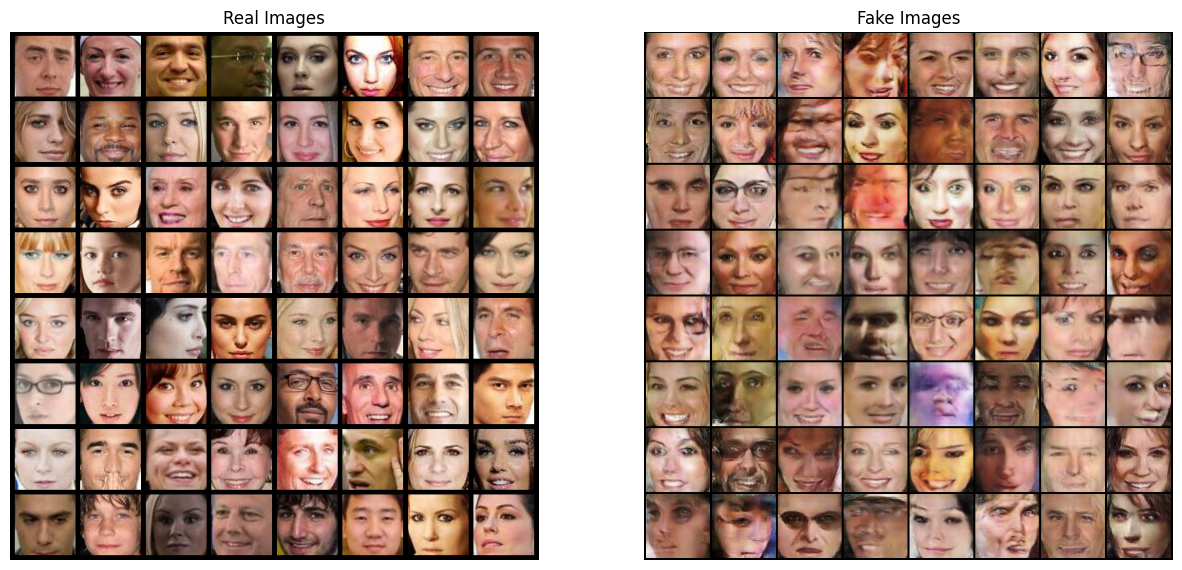

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

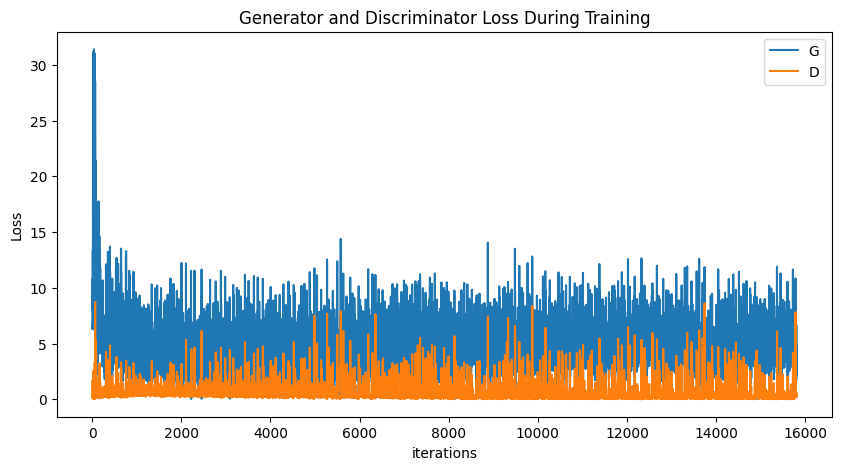

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()